In [2]:
%load_ext blackcellmagic

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
import os
import pathlib
from tqdm import tqdm_notebook as tqdm
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import RunningAverage
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.handlers import ModelCheckpoint
from sklearn.model_selection import train_test_split 
from ignite.metrics import Loss
from functools import partial
from collections import defaultdict

In [4]:
torch.__version__, np.__version__

('1.3.1', '1.16.3')

For training versions: ('1.3.1', '1.16.3') was used

In [7]:
config = {
    "data_path": "./data/train_size_1024_768",
    "device": "cuda",
    "test_size": 0.1,
    "random_seed": 42,
    "resize": (512, 384),
    "batch_size": 4,
    "learning_rate": 0.0001
}

In [10]:
labels_folder = pathlib.Path(config["data_path"]).resolve() / "labels"
all_names = [x.name for x in labels_folder.iterdir() if x.is_file()]
train_idx, test_idx = train_test_split(
    np.arange(len(all_names)),
    test_size=config["test_size"],
    random_state=config["random_seed"],
    shuffle=True,
)
train_names = [x for i, x in enumerate(all_names) if i in train_idx]
test_names = [x for i, x in enumerate(all_names) if i in test_idx]

In [15]:
def load_input_image(path, out_size, mean):
    input_image = Image.open(path).resize(out_size, Image.LANCZOS)
    input_array = np.array(input_image, dtype=np.float32)
    return input_image, ((torch.from_numpy(input_array) - mean) / 255.0).permute(2, 0, 1)


def load_label_image(path, out_size):
    label_image = Image.open(path).resize(out_size, Image.NEAREST)
    label_array = np.array(label_image)[:, :, 0]
    label_array[(label_array <= 128) & (label_array > 0)] = 1
    label_array[label_array > 128] = 2
    return label_image, torch.LongTensor(label_array)


class SegmentationDataset(Dataset):
    def __init__(
        self,
        data_path,
        file_names,
        dataset_mean=(69.2614, 55.9220, 32.6043),
        out_size=(512, 384),
        load_augumentations=True,
    ):
        images_folder = pathlib.Path(data_path).resolve() / "images"
        labels_folder = pathlib.Path(data_path).resolve() / "labels"
        all_names = file_names
        self.all_pairs = [(images_folder / name, labels_folder / name) for name in all_names]
        self.out_size = out_size
        self.mean = torch.tensor(dataset_mean)
        self.all_data = []
        self.all_images = []
        for input_path, label_path in tqdm(self.all_pairs, desc="Loading images to RAM"):
            input_image, input_normalized = load_input_image(input_path, self.out_size, self.mean)
            label_image, label_long = load_label_image(label_path, self.out_size)
            self.all_data.append((input_normalized, label_long))
            self.all_images.append((input_image, label_image))
        if load_augumentations:
            augumented_folder = images_folder / "output"
            all_augumented_files = list(augumented_folder.iterdir())
            for name in tqdm(all_names, desc="Loading augumentations to RAM"):
                input_paths = [
                    x
                    for x in all_augumented_files
                    if f"_{name}_" in x.name and not x.name.startswith("_groundtruth")
                ]
                label_paths = [
                    x
                    for x in all_augumented_files
                    if f"_{name}_" in x.name and x.name.startswith("_groundtruth")
                ]
                pairs = defaultdict(list)
                for input_path in input_paths:
                    pairs[input_path.name.split("_")[3]].append(input_path)
                for label_path in label_paths:
                    pairs[label_path.name.split("_")[5]].append(label_path)
                for input_path, label_path in list(pairs.values()):
                    input_image, input_normalized = load_input_image(input_path, self.out_size, self.mean)
                    label_image, label_long = load_label_image(label_path, self.out_size)
                    self.all_data.append((input_normalized, label_long))
                    self.all_images.append((input_image, label_image))

    def __len__(self):
        return len(self.all_data)

    def __getitem__(self, idx):
        return self.all_data[idx]

    def get_image(self, idx):
        return self.all_images[idx]

In [29]:
train_dataset = SegmentationDataset(config["data_path"], train_names, out_size=config["resize"])

In [30]:
test_dataset = SegmentationDataset(
    config["data_path"], test_names, out_size=config["resize"], load_augumentations=False
)

In [31]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.double_conv(x)

In [32]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, dropout):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
            nn.Dropout2d(p=dropout)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [33]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, dropout, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = nn.Sequential(
            DoubleConv(in_channels, out_channels), 
            nn.Dropout2d(p=dropout)
        )

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


In [34]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [35]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128, 0.2)
        self.down2 = Down(128, 256, 0.2)
        self.down3 = Down(256, 512, 0.2)
        self.down4 = Down(512, 512, 0.5)
        self.up1 = Up(1024, 256, 0.2, bilinear)
        self.up2 = Up(512, 128, 0.2, bilinear)
        self.up3 = Up(256, 64, 0.2, bilinear)
        self.up4 = Up(128, 64, 0.0, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [36]:
def dice_loss(logits, true, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    print(logits.shape)
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

In [37]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        print(logits.shape)
        probs = F.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score

### Training

In [56]:
model = UNet(3,3)
model_path = "./models/unet_W512_H384_1_cel=0.291518.pth"
model.load_state_dict(torch.load(model_path))
model.to(config["device"])

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [51]:
def improvement_function(testing_evaluator, test_data_loader, trainer):
    testing_evaluator.run(test_data_loader)
    metrics = testing_evaluator.state.metrics
    print("Validation Results - Epoch: {}  Avg loss: {:.3f}".format(trainer.state.epoch, metrics["cel"]))

    return -metrics["cel"]


train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=config["learning_rate"])
loss = nn.CrossEntropyLoss()

trainer = create_supervised_trainer(model, optimizer, loss, device=config["device"])
evaluator = create_supervised_evaluator(model, metrics={"cel": Loss(loss)}, device=config["device"])

checkpoint = ModelCheckpoint(
    "./models",
    f"unet",
    score_name="cel",
    score_function=partial(improvement_function, evaluator, test_data_loader),
    n_saved=2,
    create_dir=True,
    require_empty=False,
)

trainer.add_event_handler(
    Events.EPOCH_COMPLETED, checkpoint, {f"W{config['resize'][0]}_H{config['resize'][1]}": model}
)

RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

pbar = ProgressBar(persist=True)
pbar.attach(trainer, ["loss"])

state = trainer.run(train_data_loader, max_epochs=1)

Validation Results - Epoch: 1  Avg loss: 0.525



In [90]:
model.train()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [59]:
def spot_check_model(model, dataset, idx, config):
    result = model.forward(dataset[idx][0].unsqueeze(0).to(config["device"]))
    probab = nn.Softmax(dim=0).forward(result[0])
    result_cuda = probab.argmax(dim=0)
    numpy_result = result_cuda.cpu().numpy()
    numpy_result[numpy_result == 1] = 128
    numpy_result[numpy_result == 2] = 255
    return Image.fromarray(numpy_result.astype("uint8"), mode="L"), dataset.get_image(idx)[1]

In [60]:
pred, true = spot_check_model(model, test_dataset, 0, config)

In [94]:
%%time
test_bayesian = []
with torch.no_grad():
    input_image = test_dataset[0][0].unsqueeze(0).to(config["device"])
    for i in range(100):
        result = model.forward(input_image)
        probab = nn.Softmax(dim=0).forward(result[0])
        test_bayesian.append(probab.cpu().numpy())

CPU times: user 13.6 s, sys: 5.84 s, total: 19.5 s
Wall time: 19.5 s


In [95]:
final_bayesian = np.array(test_bayesian)

In [103]:
mean = final_bayesian.mean(axis=0)

In [111]:
std = final_bayesian.std(axis=0)

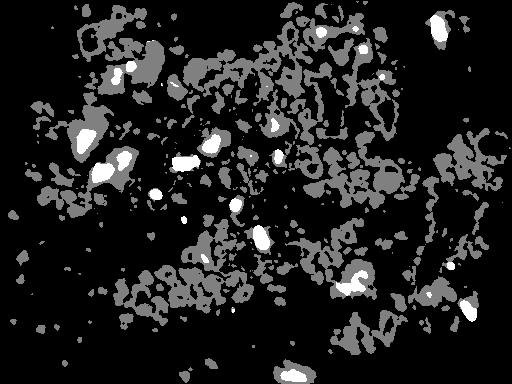

In [108]:
mean_argmax = mean.argmax(axis=0)
mean_argmax[mean_argmax == 1] = 128
mean_argmax[mean_argmax == 2] = 255
Image.fromarray(mean_argmax.astype("uint8"), mode="L")

In [119]:
std[2, :, :]

array([[0.00679136, 0.00972017, 0.01438017, ..., 0.00264438, 0.00234041,
        0.00274962],
       [0.01472475, 0.02599863, 0.03074678, ..., 0.0019768 , 0.0019423 ,
        0.00289577],
       [0.02029848, 0.03233717, 0.02645082, ..., 0.00172635, 0.00147486,
        0.00243558],
       ...,
       [0.00594782, 0.00492856, 0.00425843, ..., 0.0033681 , 0.00607261,
        0.00509929],
       [0.00834171, 0.00534286, 0.00440331, ..., 0.0034657 , 0.00400447,
        0.00371281],
       [0.00551793, 0.00588788, 0.00517609, ..., 0.00279758, 0.00251092,
        0.00309261]], dtype=float32)

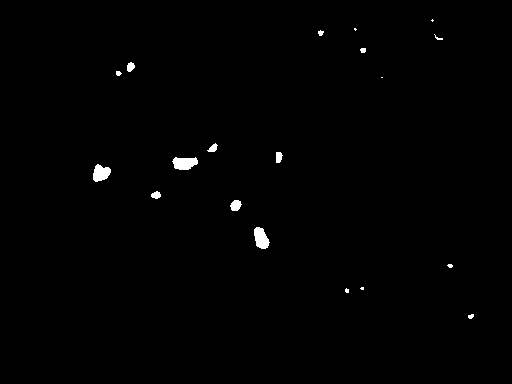

In [89]:
Image.fromarray((numpy_probabs[2, :, :] > 0.33).astype("uint8") * 255, mode="L")

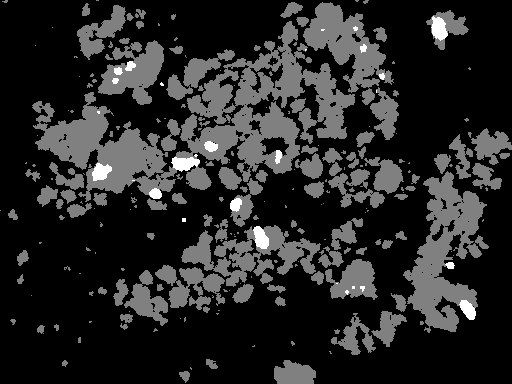

In [62]:
true

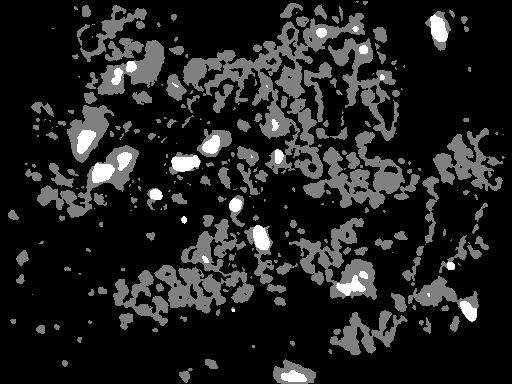

In [48]:
pred

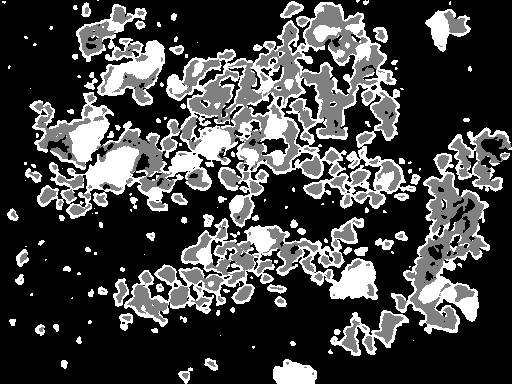

In [55]:
pred